<a href="https://colab.research.google.com/github/shirshmohan/Kidney-Stone-Classfication-Project/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [3]:
base_path = '/content/drive/MyDrive/MinorProject/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
categories = ["Cyst", "Normal", "Stone", "Tumor"]

In [4]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [5]:
df.head()

,image_path,label
0,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Cyst
1,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Cyst
2,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Cyst
3,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Cyst
4,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Cyst


In [6]:
df.tail()

,image_path,label
12444,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12445,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12446,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12447,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor
12448,/content/drive/MyDrive/MinorProject/CT-KIDNEY-...,Tumor


In [7]:
df.shape

(12449, 2)

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

,0
image_path,0
label,0


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_label_distribution(df, label_column="label", figsize=(10, 6), palette="viridis"):
    """
    Visualizes the distribution of labels in a DataFrame using count and pie charts.

    Args:
        df (pd.DataFrame): The DataFrame containing the label data.
        label_column (str): The name of the column containing the labels. Defaults to "label".
        figsize (tuple): The figure size for the plots. Defaults to (10, 6).
        palette (str): The color palette to use. Defaults to "viridis".
    """
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df, x=label_column, palette=palette)
    plt.title(f"Distribution of {label_column.capitalize()} - Count Plot")
    plt.xlabel(label_column.capitalize())
    plt.ylabel("Count")

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout() # Prevents labels from being cut off
    plt.show()

    label_counts = df[label_column].value_counts()
    plt.figure(figsize=figsize)
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette(palette))
    plt.title(f"Distribution of {label_column.capitalize()} - Pie Chart")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-3575654125.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=label_column, palette=palette)


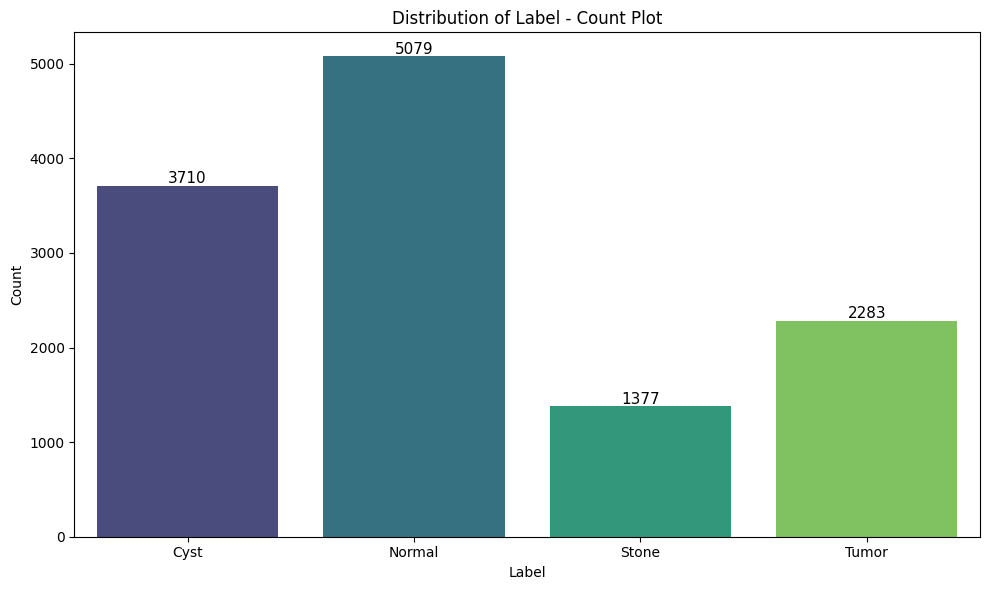

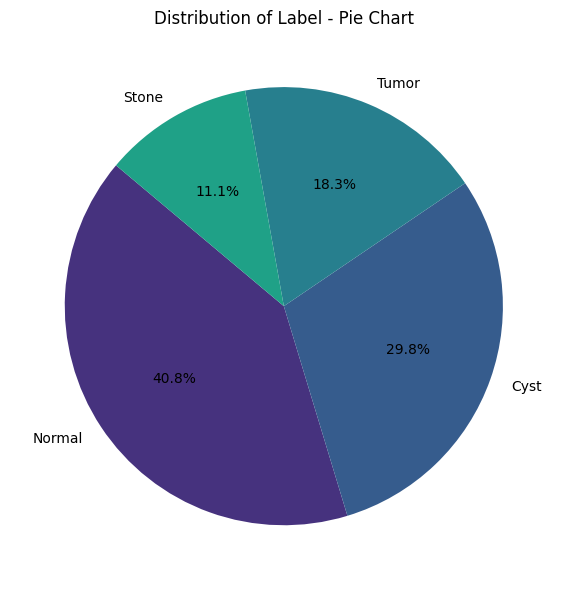

In [11]:
visualize_label_distribution(df)

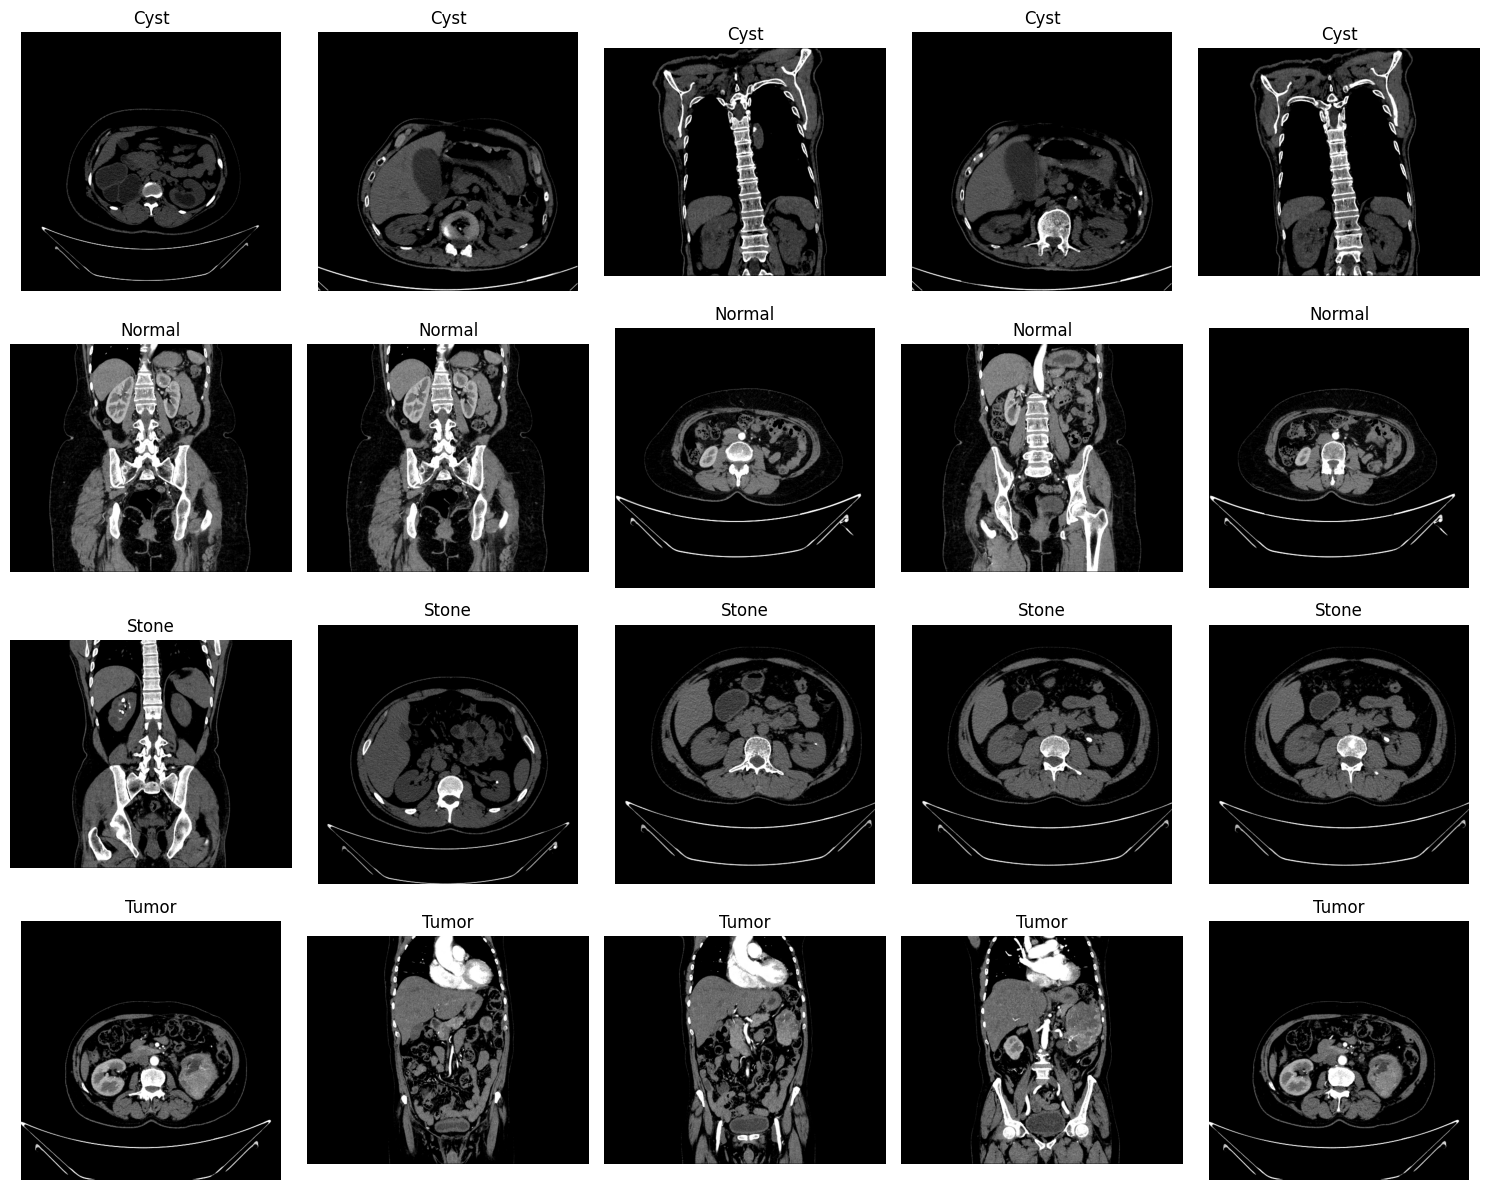

In [12]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [14]:
df = df[['image_path', 'category_encoded']]

In [17]:
from imblearn.over_sampling import RandomOverSampler

train_df, temp_df = train_test_split(
    df,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df['category_encoded']
)


valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df['category_encoded']
)

ros = RandomOverSampler(random_state=42)


X_train_resampled, y_train_resampled = ros.fit_resample(
    train_df[['image_path']],
    train_df['category_encoded']
)


train_df_balanced = pd.DataFrame(X_train_resampled, columns=['image_path'])
train_df_balanced['category_encoded'] = y_train_resampled

print("Balanced Training Set Counts:\n", train_df_balanced['category_encoded'].value_counts())
print("\nOriginal (Imbalanced) Test Set Counts:\n", test_df['category_encoded'].value_counts())

Balanced Training Set Counts:
 category_encoded
1    4063
0    4063
2    4063
3    4063
Name: count, dtype: int64

Original (Imbalanced) Test Set Counts:
 category_encoded
1    508
0    371
3    228
2    138
Name: count, dtype: int64


In [18]:
print("\nClass distribution before oversampling:")
print(df['category_encoded'].value_counts())


Class distribution before oversampling:
category_encoded
1    5079
0    3710
3    2283
2    1377
Name: count, dtype: int64


In [19]:
train_df_balanced['category_encoded'] = train_df_balanced['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
print("TensorFlow version:", tf.__version__)
print("Success! Layer imported.")

TensorFlow version: 2.19.0
Success! Layer imported.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [21]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_balanced,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 16252 validated image filenames belonging to 4 classes.


In [23]:
# Convert the encoded labels to strings
train_df_balanced['category_encoded'] = train_df_balanced['category_encoded'].astype(str)
valid_df['category_encoded'] = valid_df['category_encoded'].astype(str)
test_df['category_encoded'] = test_df['category_encoded'].astype(str)

In [24]:
valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1245 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
from tensorflow.keras import layers

class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding='valid')

    def call(self, images):
        patches = self.proj(images)
        patches = tf.reshape(patches, (tf.shape(patches)[0], -1, self.embed_dim))
        return patches

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    def call(self, inputs):
        return self.attention(inputs, inputs)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(num_heads, embed_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate)
        ])

    def call(self, inputs):
        x = self.layernorm1(inputs)
        x = self.attention(x)
        x = x + inputs
        x = self.layernorm2(x)
        x = self.mlp(x)
        return x + inputs

class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, embed_dim, num_heads, num_blocks, mlp_dim, num_classes, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, embed_dim)

        height, width, _ = image_size
        num_patches = (height // patch_size) * (width // patch_size)

        self.pos_embed = self.add_weight(
            name="pos_embed",
            shape=(1, num_patches + 1, embed_dim),
            initializer=tf.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, embed_dim),
            initializer=tf.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

        self.dropout = layers.Dropout(dropout_rate)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, mlp_dim, dropout_rate) for _ in range(num_blocks)]
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = self.patch_embed(images)

        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)
        x = tf.concat([cls_tokens, patches], axis=1)

        pos_embed = tf.repeat(self.pos_embed, repeats=batch_size, axis=0)
        x = x + pos_embed
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.layernorm(x)
        cls_token_final = x[:, 0]
        return self.classifier(cls_token_final)


image_size = (224, 224, 3)
patch_size = 16
embed_dim = 256
num_heads = 8
num_blocks = 6
mlp_dim = 256
num_classes = 4
dropout_rate = 0.1
learning_rate = 1e-5

vit_model = VisionTransformer(image_size=image_size,
                              patch_size=patch_size,
                              embed_dim=embed_dim,
                              num_heads=num_heads,
                              num_blocks=num_blocks,
                              mlp_dim=mlp_dim,
                              num_classes=num_classes,
                              dropout_rate=dropout_rate)

vit_model = VisionTransformer(image_size=image_size,
                              patch_size=patch_size,
                              embed_dim=embed_dim,
                              num_heads=num_heads,
                              num_blocks=num_blocks,
                              mlp_dim=mlp_dim,
                              num_classes=num_classes,
                              dropout_rate=dropout_rate)

vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint


epochs=10
checkpoint = ModelCheckpoint(
    'best_vit_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history = vit_model.fit(
    train_gen_new,
    epochs=epochs,
    validation_data=valid_gen_new,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4486 - loss: 1.1845
Epoch 1: val_loss improved from inf to 0.36486, saving model to best_vit_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 7370s 7s/step - accuracy: 0.4487 - loss: 1.1843 - val_accuracy: 0.8610 - val_loss: 0.3649
Epoch 2/10
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8907 - loss: 0.2882
Epoch 2: val_loss improved from 0.36486 to 0.11750, saving model to best_vit_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 167s 164ms/step - accuracy: 0.8907 - loss: 0.2881 - val_accuracy: 0.9534 - val_loss: 0.1175
Epoch 3/10
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9791 - loss: 0.0655
Epoch 3: val_loss improved from 0.11750 to 0.01413, saving model to best_vit_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 165s 162ms/step - accuracy: 0.9791 - loss: 0.0655 - val_accuracy: 0.9976 - val_loss: 0.0141
Epoch 4/10
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9968 - loss: 0.0141
Epoch 4: val_

In [28]:
# Move the saved model to your Drive so you don't lose it
import shutil
shutil.copy('best_vit_model.keras', '/content/drive/MyDrive/MinorProject/')

'/content/drive/MyDrive/MinorProject/best_vit_model.keras'

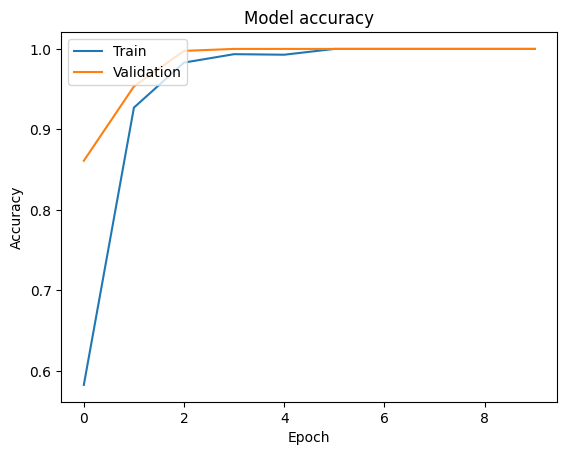

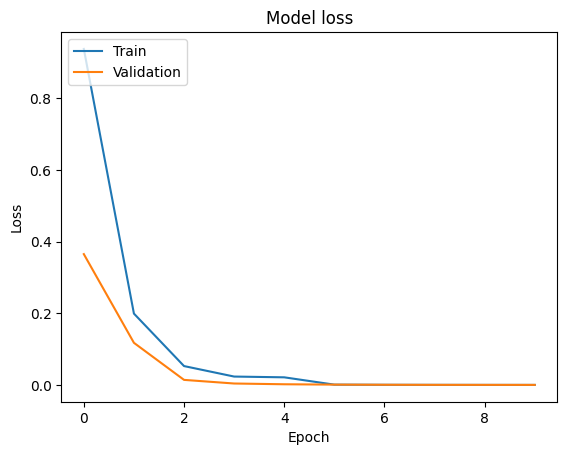

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
test_labels = test_gen_new.classes
predictions = vit_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 834s 11s/step


In [31]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       371
           1       1.00      1.00      1.00       508
           2       1.00      1.00      1.00       138
           3       1.00      1.00      1.00       228

    accuracy                           1.00      1245
   macro avg       1.00      1.00      1.00      1245
weighted avg       1.00      1.00      1.00      1245



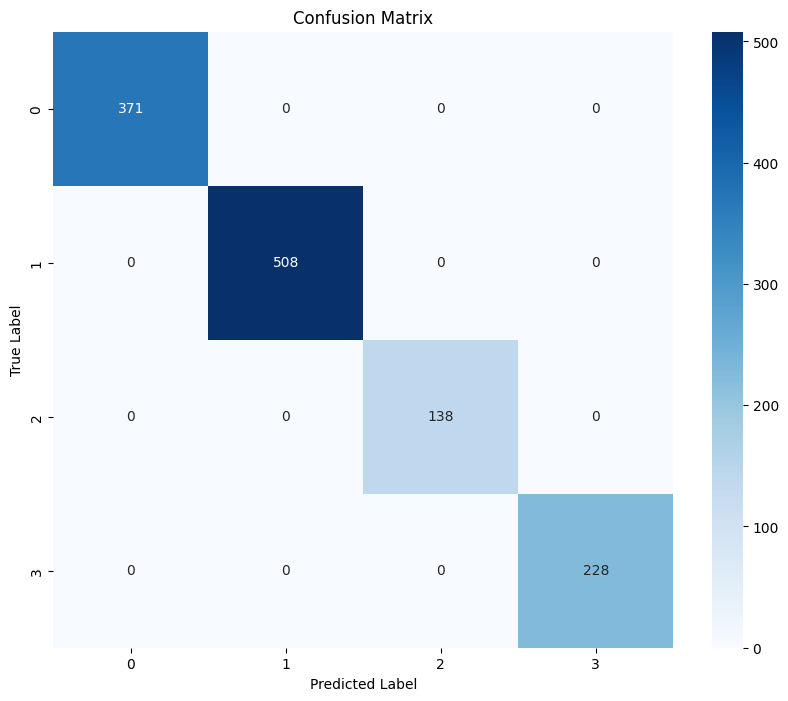

In [32]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()